In [1]:
import torch
import tiktoken
from torch import nn

In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))

In [3]:
from src.gpt_arch import GPTModel, generate_text_simple, generate
from src.tokenization_embeddings import text_to_token_ids, token_ids_to_text, create_dataloader_v1
from src.pretrain_model import train_model_simple
from src.utility import plot_losses

In [ ]:
GPT_CONFIG_124M = {
"vocab_size": 50257,
"context_length": 256,
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1,
"qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
torch.manual_seed(123)
token_ids = generate(
model=model,
idx=text_to_token_ids("Every effort moves you", tokenizer),
max_new_tokens=15,
context_size=GPT_CONFIG_124M["context_length"],
top_k=25,
temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you inferred rolleduint fabricationagos remarkably hereuced saints freewaylookOkayRand salary baseless


In [7]:
## data loading to train on verdict
file_path = "data/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [8]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [9]:
torch.manual_seed(123)
train_loader = create_dataloader_v1(
train_data,
batch_size=2,
max_length=GPT_CONFIG_124M["context_length"],
stride=GPT_CONFIG_124M["context_length"],
drop_last=True,
shuffle=True,
num_workers=0
)
val_loader = create_dataloader_v1(
val_data,
batch_size=2,
max_length=GPT_CONFIG_124M["context_length"],
stride=GPT_CONFIG_124M["context_length"],
drop_last=False,
shuffle=False,
num_workers=0
)

In [10]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [14]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
model.parameters(),
lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=5, eval_iter=5,
start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.821, Val loss 9.931
Ep 1 (Step 000005): Train loss 8.069, Val loss 8.334
Every effort moves you, extracting Sh. Hut Apply Drawn him oforthodox downright./ tie prostitutes reflectedв  position,perors's desire withdrew Weston Aviv 89 wonder share highestMrs arsonCome996exampleRW fictitious Derek_ again propagationike  512, it depicting gratitude, his
Ep 2 (Step 000010): Train loss 6.623, Val loss 7.049
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.599
Every effort moves you " because." " in me chestwere I I me and his.    Nether see with established and couldn signify ding significCompany It- patrols she monumentalascular setudd his cameraste don.   " infused its a
Ep 3 (Step 000020): Train loss 5.579, Val loss 6.485
Ep 3 (Step 000025): Train loss 5.519, Val loss 6.405
Every effort moves you. factorsmer to aud"; from on himself, in of resources. Kubrick down, his do almost more! cheap lean really--redictand; he half tragedy pictures voice eyesry an par

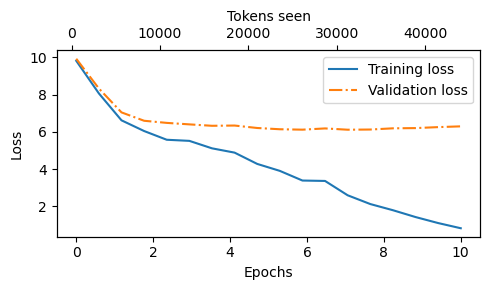

In [15]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [16]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [17]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
model=model,
idx=text_to_token_ids("Every effort moves you", tokenizer),
max_new_tokens=25,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you demands Porsche thought Jack-press."

A handsome Tam onmaked in't look" no great her nominal, I


In [18]:
torch.manual_seed(123)
token_ids = generate(
model=model,
idx=text_to_token_ids("Every effort moves you", tokenizer),
max_new_tokens=15,
context_size=GPT_CONFIG_124M["context_length"],
top_k=25,
temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen a little wild--I was such
"I enough


In [ ]:
# ## for saving the model
# torch.save({
# "model_state_dict": model.state_dict(),
# "optimizer_state_dict": optimizer.state_dict(),
# },
# "model/model_and_optimizer.pth"
# )